In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import rebound
from scipy.misc import imread

plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
sa = rebound.SimulationArchive('sa0000000.bin')
sim0 = sa[0]
def makesystem(seed, emax):
    random.seed(seed)
    ps = sim0.particles
    sim = rebound.Simulation()
    sim.add(m=ps[0].m)
    for i in [1,2,3]:
        sim.add(m=ps[i].m, a=ps[i].a, e=random.random()*emax, pomega=random.random()*2*np.pi, inc=random.random()*np.pi/180, Omega=random.random()*2*np.pi)
    return sim
    
def predict_stable(seed, emax=0.2):
    sim = makesystem(seed, emax)
    return (seed, model.predict_stable(sim))

from rebound.plotting import fading_line

def plot(fig, ax, ID):
    sa = rebound.SimulationArchive('sa0000000.bin'.format(ID))
    sim = sa[0]
    colors = ['red', 'green', 'blue']
    for p,c in zip(sim.particles[1:], colors):
        o = np.array(p.sample_orbit())
        lc = fading_line(o[:,0], o[:,1], linewidth=3, color=c, alpha=0.1)
        ax.add_collection(lc)
    return fig, ax

def randomplot(fig, ax, seed, emax, alpha=0.1):
    sim = makesystem(seed, emax=emax)
    colors = ['dodgerblue','yellow','crimson']
    for p,c in zip(sim.particles[1:], colors):
        o = np.array(p.sample_orbit())
        ax.plot(o[:,0], o[:,1], linewidth=1, color=c, zorder=0, alpha=alpha)
    return fig, ax

/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:86: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/dtamayo/Documents/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [3]:
%%time
from spock import FeatureClassifier
model = FeatureClassifier()

CPU times: user 918 ms, sys: 137 ms, total: 1.06 s
Wall time: 1.12 s


In [4]:
%%time

try:
    stableseeds = np.loadtxt('prseeds.txt')
except: 
    Nsamp=30000
    res = np.zeros((Nsamp, 2))
    for seed in range(Nsamp):
        res[seed] = predict_stable(seed, emax=0.2)
    
    mask = res[:,1] > 0.01 # discard smallest probabilities to limit # plotted orbits
    stableseeds = res[mask]
    np.savetxt('prseeds.txt', stableseeds)

CPU times: user 67.6 ms, sys: 4.53 ms, total: 72.1 ms
Wall time: 70.8 ms


# 2D array of (seed, stability prob)

In [5]:
stableseeds.shape

(3215, 2)

In [37]:
eff_samples = stableseeds[:,1].sum() # add up all probabilities to plot same # of effective samples for equal alpha in both and fair comparison
eff_samples

963.448148121126

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


CPU times: user 1min 4s, sys: 610 ms, total: 1min 5s
Wall time: 1min 5s


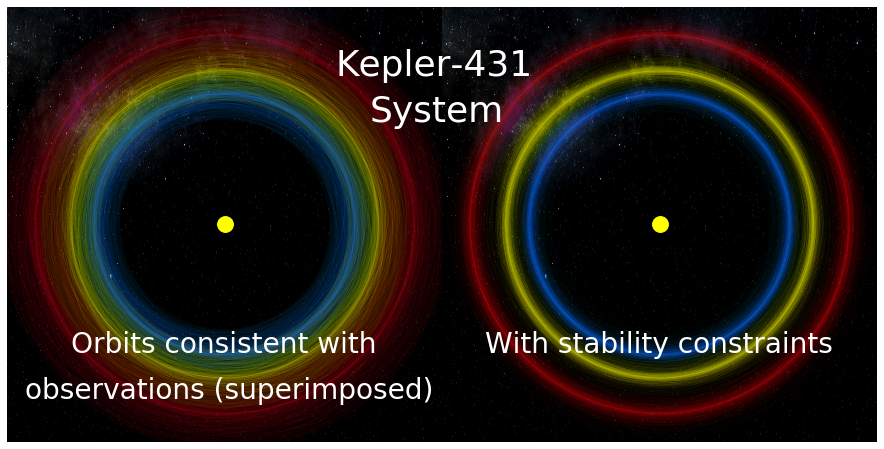

In [39]:
%%time

fig, axarr = plt.subplots(ncols=2, figsize=(16,8))
plt.subplots_adjust(wspace=-0.05)
lim=0.12

for i in range(int(eff_samples)):
    fig, axarr[0] = randomplot(fig, axarr[0], i, emax=0.2, alpha=0.02)

for seed, prob in stableseeds:
    fig, axarr[1] = randomplot(fig, axarr[1], int(seed), emax=0.2, alpha=0.02*prob)

for ax in axarr:
    ax.set_rasterization_zorder(1)
    ax.scatter([0],[0], s=250, color='yellow')
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.axis('off')
    
    bkg = imread('US_background_image.png')
    ax.imshow(bkg, extent=[-lim, lim, -lim, lim], zorder=-1)
    
fig.text(0.42, 0.76, 'Kepler-431', color='w', fontsize=36)
fig.text(0.45, 0.68, 'System', color='w', fontsize=36)

fig.text(0.19, 0.28, 'Orbits consistent with', color='w', fontsize=28)
fig.text(0.15, 0.2, 'observations (superimposed)', color='w', fontsize=28)

fig.text(0.55, 0.28, 'With stability constraints', color='w', fontsize=28)


fig.savefig('spockpr.jpg')